In [48]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp

import spatial_selection

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [14]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')
aus_shape

,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,AUS,Australia,7.688095e+06,http://linked.data.gov.au/dataset/asgsed3/AUS/AUS,"MULTIPOLYGON (((96.91524 -12.15313, 96.91523 -..."


## Get NorESM2-MM data

In [4]:
noresm_dates = ['19900101-19991231', '20000101-20091231', '20100101-20141231']
noresm_tmax_files = [f'/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_{dates}.nc' for dates in noresm_dates]
noresm_tmax_files

['/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc']

In [5]:
noresm_ds = xr.open_mfdataset(noresm_tmax_files)
noresm_ds = noresm_ds.sel({'time': slice(start_date, end_date)})
noresm_ds = noresm_ds.drop('height')

In [6]:
noresm_annual_clim = noresm_ds.mean('time', keep_attrs=True)
noresm_seasonal_clim = noresm_ds.groupby('time.season').mean('time', keep_attrs=True)
noresm_monthly_clim = noresm_ds.groupby('time.month').mean('time', keep_attrs=True)

## Get AGCD data

In [7]:
agcd_years = np.arange(1995, 2015, 1)
agcd_tmax_files = [f'/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_{year}0101-{year}1231_daily.nc' for year in agcd_years]
agcd_tmax_files

['/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19950101-19951231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19960101-19961231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19970101-19971231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19980101-19981231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19990101-19991231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20000101-20001231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20010101-20011231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20020101-20021231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20030101-20031231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20040101-20041231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20050101-20051231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20060101-20061231_daily.nc',
 '/g/data/xv83/agcd-csiro/tm

In [8]:
agcd_ds = xr.open_mfdataset(agcd_tmax_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [9]:
agcd_ds

<xarray.Dataset>
Dimensions:    (lon: 886, time: 7305, bnds: 2, lat: 691)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time       (time) datetime64[ns] 1995-01-01T09:00:00 ... 2014-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (time, lon, bnds) float32 dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float32 dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax       (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 17:20:16 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [10]:
agcd_annual_clim = agcd_ds.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [19]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  2min 14.5s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1min 36.9s


In [33]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1min 40.8s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1min 38.2s


In [11]:
noresm_regridder = xe.Regridder(noresm_ds, agcd_ds, "bilinear")

In [12]:
noresm_annual_clim = noresm_regridder(noresm_annual_clim)
noresm_monthly_clim = noresm_regridder(noresm_monthly_clim)

In [18]:
noresm_annual_clim = spatial_selection.select_shapefile_regions(noresm_annual_clim, aus_shape)

[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.4s


In [32]:
noresm_monthly_clim = spatial_selection.select_shapefile_regions(noresm_monthly_clim, aus_shape)

[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed |  8.5s


## Mean bias

In [20]:
noresm_annual_clim = noresm_annual_clim.compute()

[########################################] | 100% Completed |  8.7s


In [21]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  1min 37.0s


In [22]:
noresm_annual_clim['tasmax'] = noresm_annual_clim['tasmax'] - 273.13
noresm_annual_clim['tasmax'].attrs['units'] = 'C'

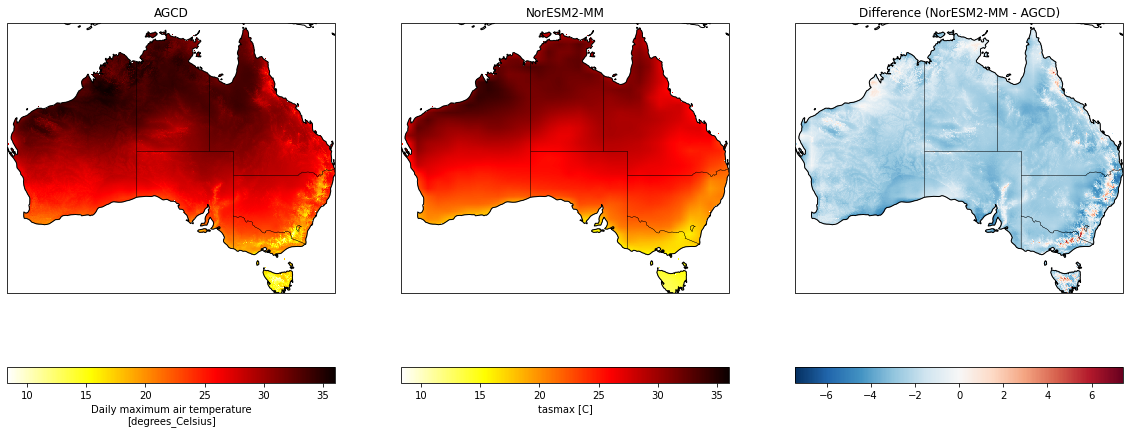

In [51]:
fig = plt.figure(figsize=[20, 9])

noresm_max = np.nanmax(noresm_annual_clim['tasmax'].values)
agcd_max = np.nanmax(agcd_annual_clim['tmax'].values)
vmax = np.nanmax([noresm_max, agcd_max])

noresm_min = np.nanmin(noresm_annual_clim['tasmax'].values)
agcd_min = np.nanmin(agcd_annual_clim['tmax'].values)
vmin = np.nanmin([noresm_min, agcd_min])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
agcd_annual_clim['tmax'].plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    vmax=vmax,
    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax1.set_title('AGCD')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
noresm_annual_clim['tasmax'].plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    vmax=vmax,
    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax2.set_title('NorESM2-MM')

diff = noresm_annual_clim['tasmax'] - agcd_annual_clim['tmax']
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
diff.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
#    cmap='hot_r',
#    vmax=vmax,
#    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax3.set_title('Difference (NorESM2-MM - AGCD)')

for ax in [ax1, ax2, ax3]:
    #ax.add_geometries(aus_shape.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
    #ax.spines['top'].set_visible(False)

#plt.suptitle(title)
plt.show()

## Temporal 

In [34]:
noresm_monthly_clim = noresm_monthly_clim.compute()

[########################################] | 100% Completed |  9.3s


In [35]:
agcd_monthly_clim = agcd_monthly_clim.compute()

[########################################] | 100% Completed |  1min 39.2s


In [36]:
noresm_monthly_clim['tasmax'] = noresm_monthly_clim['tasmax'] - 273.13
noresm_monthly_clim['tasmax'].attrs['units'] = 'C'

In [37]:
temporal_corr = xr.corr(noresm_monthly_clim['tasmax'], agcd_monthly_clim['tmax'], dim='month') 

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [42]:
noresm_temporal_std = noresm_monthly_clim['tasmax'].std(dim='month', keep_attrs=True)
agcd_temporal_std = agcd_monthly_clim['tmax'].std(dim='month', keep_attrs=True)
std_ratio = noresm_temporal_std / agcd_temporal_std

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


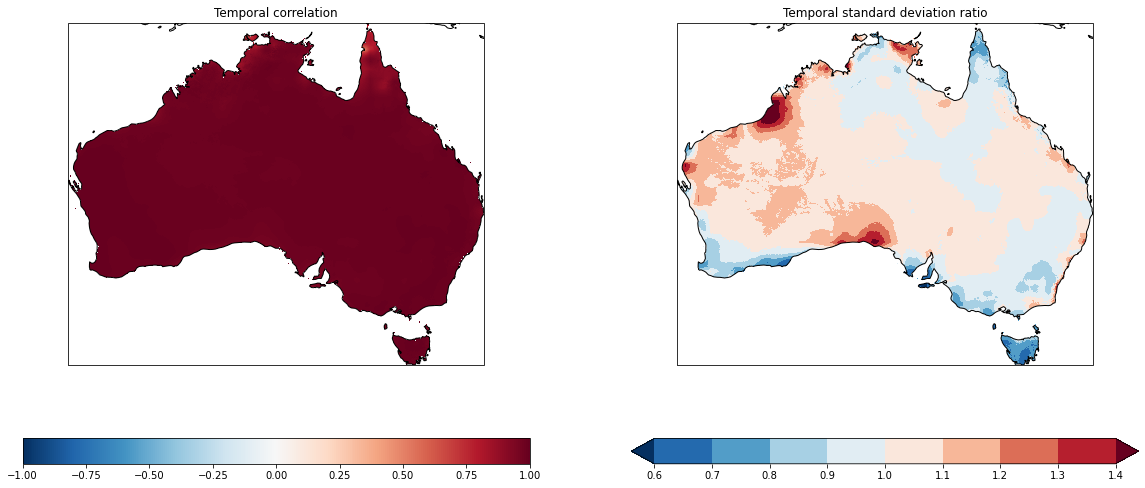

In [47]:
fig = plt.figure(figsize=[20, 9])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
temporal_corr.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=1,
    vmin=-1,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax1.set_title('Temporal correlation')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
std_ratio.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax2.set_title('Temporal standard deviation ratio')

for ax in [ax1, ax2]:
    ax.coastlines()
#plt.suptitle(title)
plt.show()

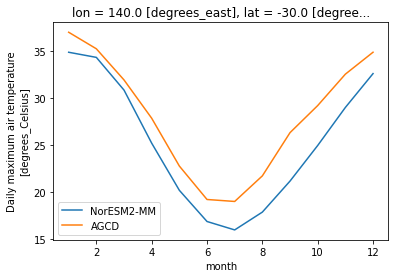

In [79]:
noresm_monthly_clim['tasmax'].sel({'lat': -30, 'lon': 140}, method='nearest').plot(label='NorESM2-MM')
agcd_monthly_clim['tmax'].sel({'lat': -30, 'lon': 140}, method='nearest').plot(label='AGCD')
plt.legend()
plt.show()